In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [55]:
import os
import pandas as pd

def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(filename,index=False)

create_csv('train',"train.csv")
create_csv('test',"test.csv")
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

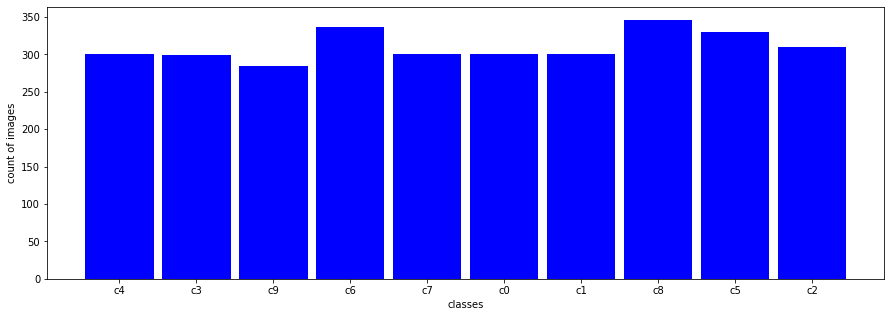

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5))
x = data_train["ClassName"].value_counts(sort=False).to_numpy()
y = data_train["ClassName"].value_counts(sort=False).index.to_numpy()
plt.bar(y,x,0.88888,color='blue')
plt.xlabel("classes")
plt.ylabel("count of images")
plt.show()

In [57]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_list.sort()
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [58]:
import pickle
with open(os.path.join("labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [59]:
from tensorflow.keras.utils import to_categorical
print(data_train['ClassName'].head())
labels = to_categorical(data_train['ClassName'])
print(labels[:5])

0    0
1    0
2    0
3    0
4    0
Name: ClassName, dtype: int64
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [60]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [61]:
from tensorflow.keras.preprocessing import image  
import numpy as np

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in (img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
____

In [43]:
checkpoint = ModelCheckpoint('model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = model.fit(train_tensors,
                          ytrain,
                          validation_data = (valid_tensors, ytest),
                          epochs=18,
                          batch_size=40,
                          shuffle=True,
                          callbacks=callbacks_list
                          )

Train on 2484 samples, validate on 622 samples
Epoch 1/18
2480/2484 [============================>.] - ETA: 0s - loss: 2.2981 - acc: 0.1270
Epoch 00001: val_acc improved from -inf to 0.18971, saving model to model.hdf5
2484/2484 [==============================] - 24s 10ms/sample - loss: 2.2980 - acc: 0.1272 - val_loss: 2.2077 - val_acc: 0.1897
Epoch 2/18
2480/2484 [============================>.] - ETA: 0s - loss: 1.9079 - acc: 0.2750
Epoch 00002: val_acc improved from 0.18971 to 0.31029, saving model to model.hdf5
2484/2484 [==============================] - 24s 10ms/sample - loss: 1.9065 - acc: 0.2754 - val_loss: 1.6464 - val_acc: 0.3103
Epoch 3/18
2480/2484 [============================>.] - ETA: 0s - loss: 1.5228 - acc: 0.4266
Epoch 00003: val_acc improved from 0.31029 to 0.51929, saving model to model.hdf5
2484/2484 [==============================] - 24s 10ms/sample - loss: 1.5233 - acc: 0.4263 - val_loss: 1.2751 - val_acc: 0.5193
Epoch 4/18
2480/2484 [============================

**ＴＲＡＩＮＩＮＧ　ＡＣＣ　ＩＳ　９８．６％　ＡＮＤ　ＶＡＬＩＤＡＴＩＯＮ　ＡＣＣ　ＩＳ　９４％

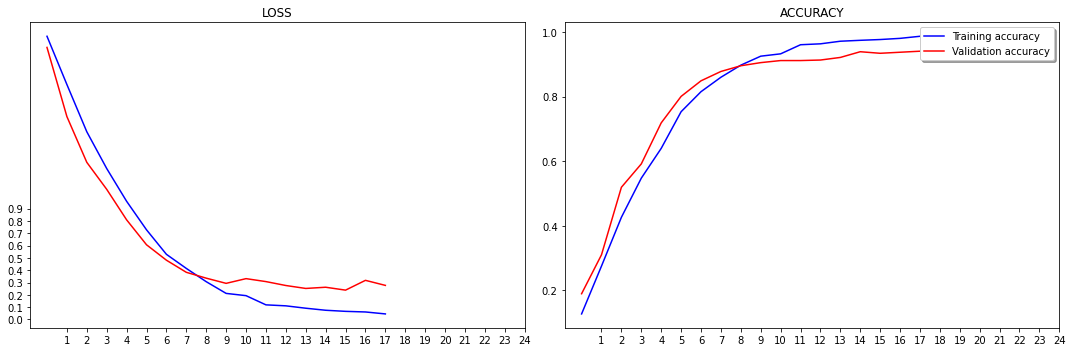

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.title.set_text("LOSS")

ax2.plot(model_history.history['acc'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))
ax2.title.set_text("ACCURACY")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [ ]:
val = ['normal driving',
      ' texting - right',
      'talking on the phone - right',
      'texting - left',
      'talking on the phone - left',
      'operating the radio',
      'drinking',
      'reaching behind',
      'hair and makeup',
      'talking to passenger']
def predict(img):
  img = image.load_img(img, target_size=(64, 64))
  img = image.img_to_array(img)
  res = model.predict((np.expand_dims(img,axis=0)/255 - 0.5))[0] > 0.5
  return val[res.tolist().index(True)]
print(predict("test/c0/img_1005.jpg"))

normal driving


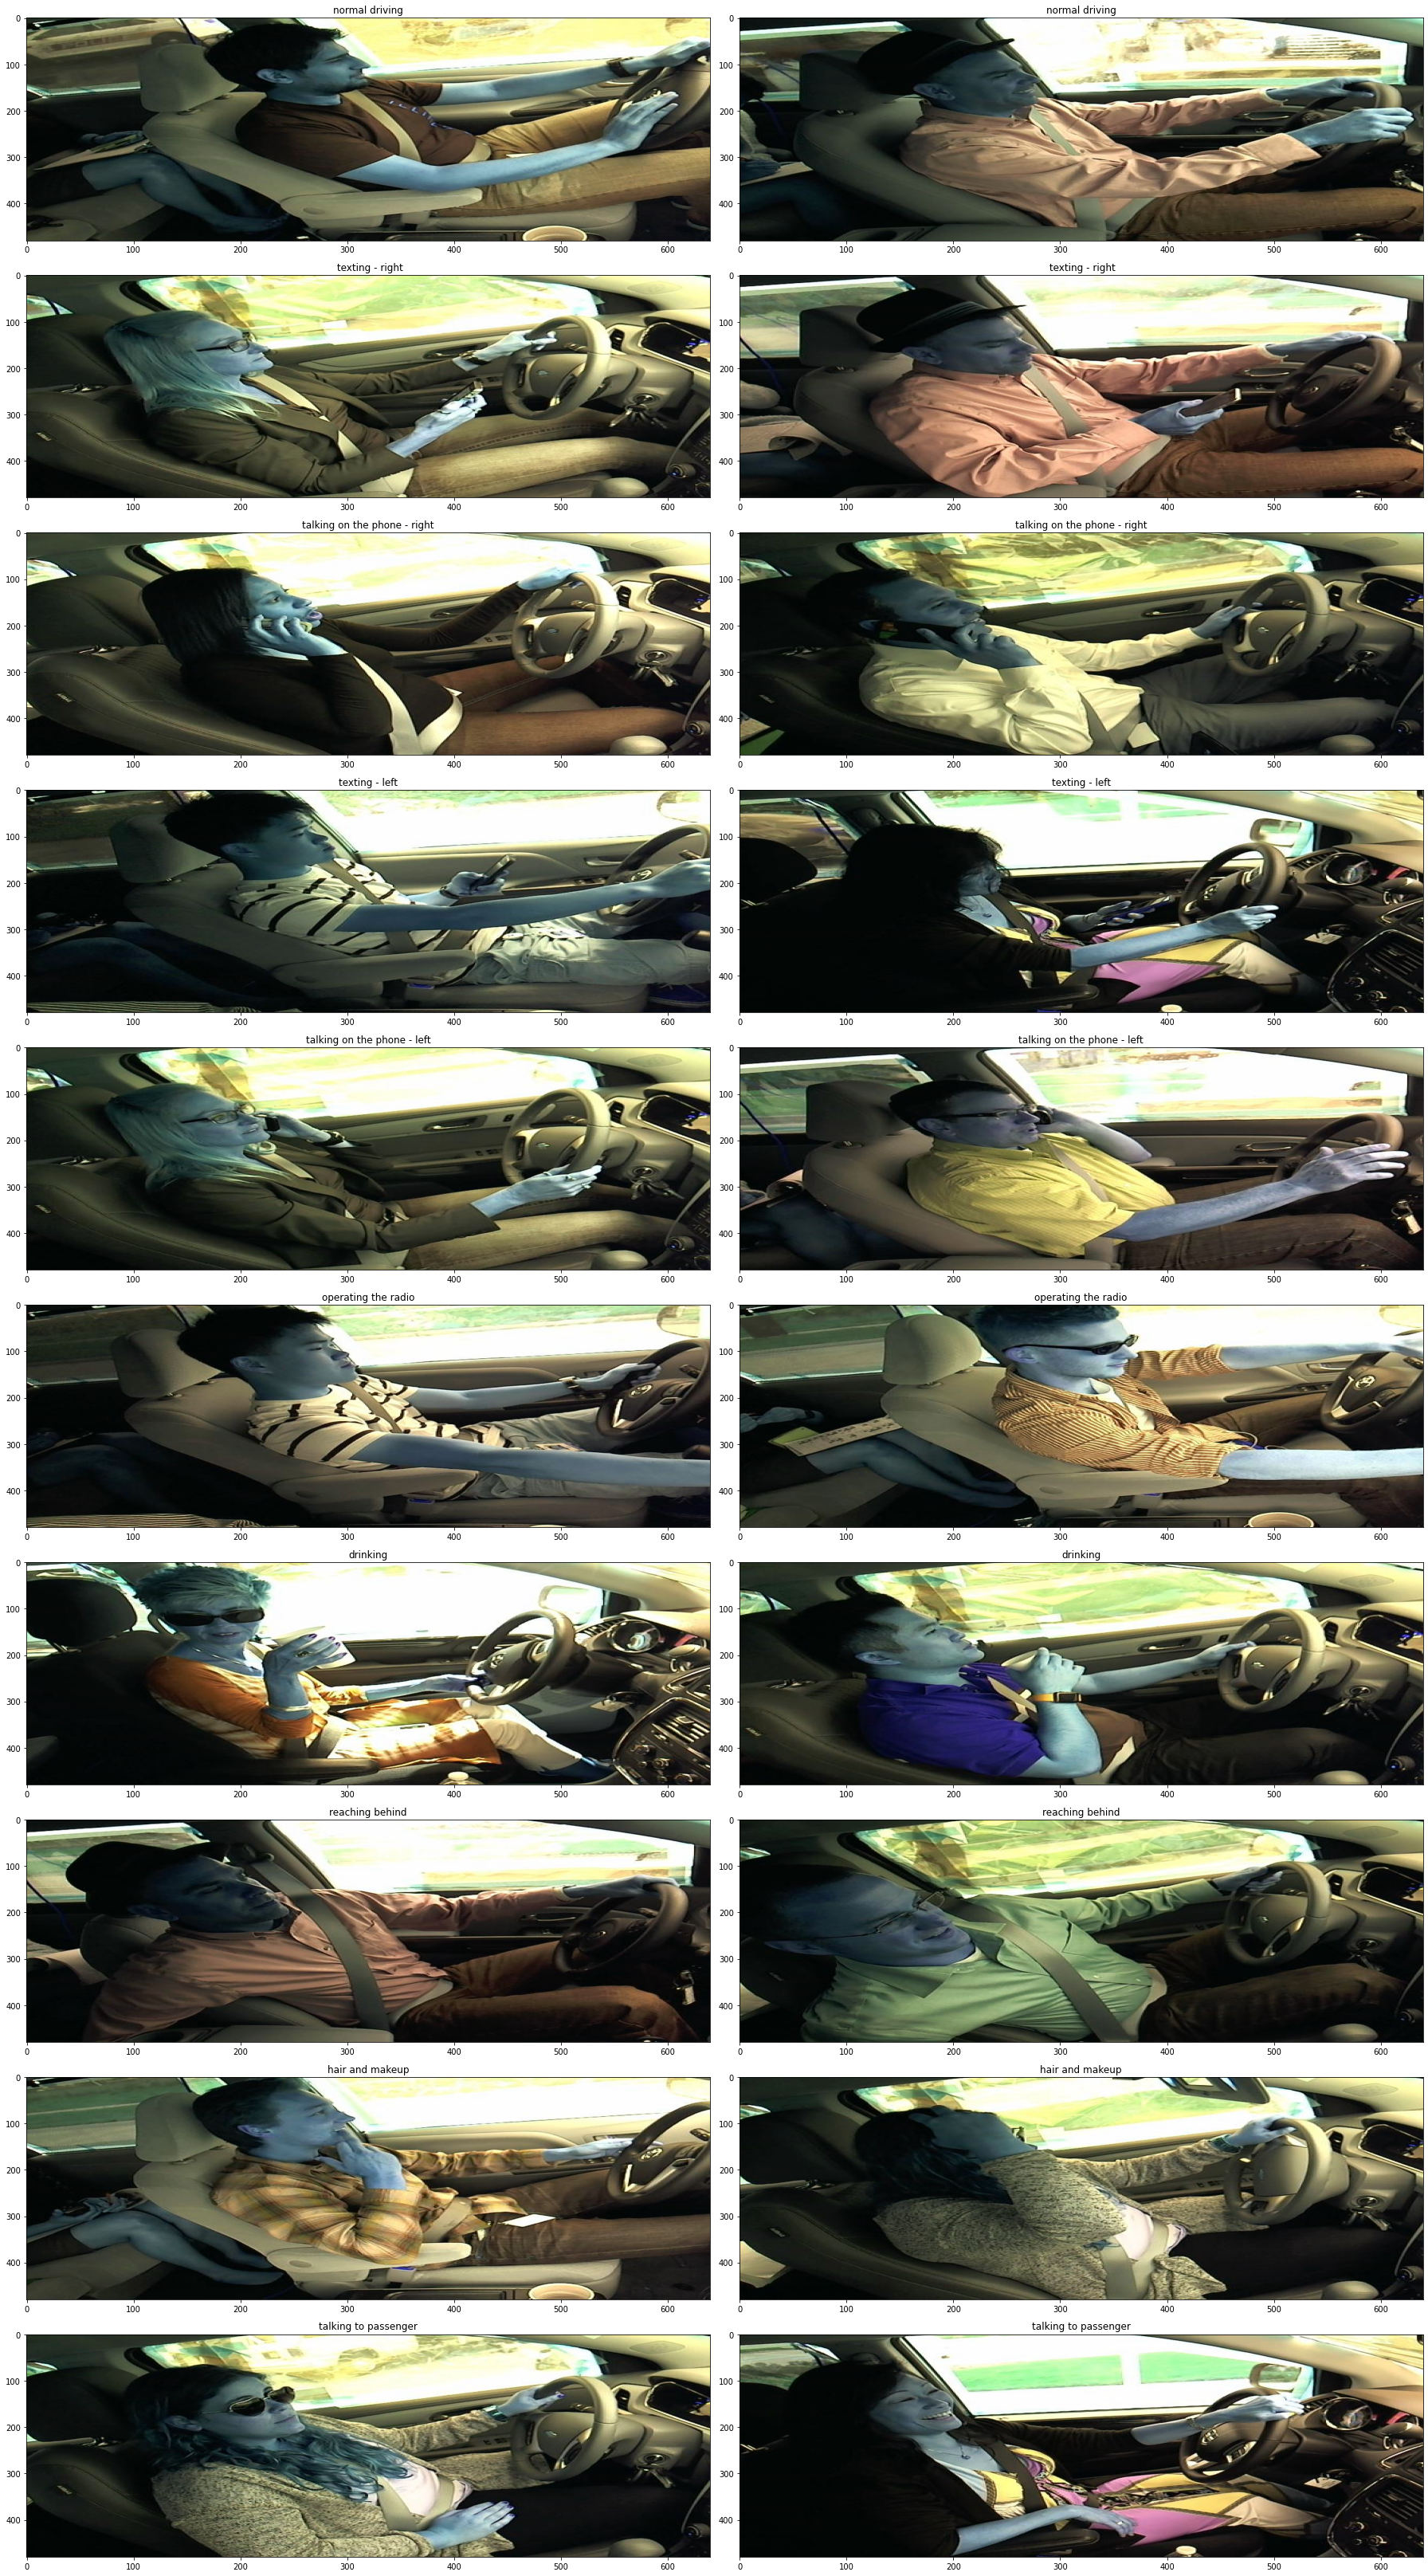

In [ ]:
import cv2
fig,ax = plt.subplots(10,2, figsize=(25,45))
images = os.listdir("test")
#print(images)
c=-1

fig.tight_layout()
for i in images:
  c+=1
  l = os.listdir("test/"+i+"/")
  #print(l)
  for j in range(2):
    imgpath = "test/{}/{}".format(i,l[j])
    load = image.load_img("test/{}/{}".format(i,l[j]), target_size=(64, 64))
    load_img = cv2.imread(imgpath)
    ax[c, j].imshow(load_img,aspect="auto")
    ax[c, j].title.set_text(predict(imgpath))

plt.tight_layout()
plt.show()


In [2]:
from tensorflow.keras.models import load_model
loadmodel = load_model("model.hdf5")
loadmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
results = loadmodel.evaluate(valid_tensors,ytest)
print("\nＡＣＣＵＲＡＣＹ　ＯＦ　ＭＯＤＥＬ on 　ＩＳ : %f"%(results[1]*100))
print("\nＭＳＥ　ＯＦ　ＭＯＤＥＬ　ＩＳ : %f"%(results[0]))

622/622 [==============================] - 1s 2ms/sample - loss: 0.2767 - acc: 0.9405

ＡＣＣＵＲＡＣＹ　ＯＦ　ＭＯＤＥＬ　ＩＳ : 94.051445

ＭＳＥ　ＯＦ　ＭＯＤＥＬ　ＩＳ : 0.276669
